In [20]:
#Import needed packages

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import minimize
from numpy.linalg import norm

In [137]:
def KPP(construct, hessianveccheck):

#################### FUNCTIONS #######################
    # Fisher's KPP Reaction Term (negative version since moved to LHS in model equation)
    def R(uvect):
        return((-1) * uvect + (uvect**2))
    
    
    # Jacobian of Fisher's KPP Rection Term
    def Rprime(uvect):
        return(np.diag(-1 + 2 * uvect))
    

    # Jacobian of (Jacobian of Fisher's KPP Reaction Term times lambda)
    def Rpplamb(lambvect):
        return(np.diag(2 * lambvect))
    

    # Solving initial bounday value problem for states in time
    def ibvpmodel(n, m, u_0, A, k, alpha):
        u = np.zeros((n,m+1))
        u[:,0] = u_0

        for j in range(1,m+1):
            u[:,j] = (A @ u[:,j-1])  - (k * R(u[:,j-1])) + (k * alpha)

        return(u)
    

    # Reduced cost function 
    def Jfun(alpha):
        n = 49
        m = 100
        h = 1 / (n+1)
        k = 0.5 * (h**2)
        s = k / (h**2)  

        # goal data
        udatam = np.zeros(n)
        x_nodes = np.zeros(n)
        for i in range(n):
            x_nodes[i] = i * h
            udatam[i] = np.cos(2 * np.pi * x_nodes[i])

        main_diag = (1 - 2 * s) * np.eye(n)
        minor_diags = s * (np.eye(n, k=-1) + np.eye(n, k=1))
        A = main_diag + minor_diags

        u = ibvpmodel(n, m, u_0, A, k, alpha)

        umalpha = u[:,m]

        redcost = (1/2) * (np.linalg.norm(umalpha - udatam)**2)
      
        return(redcost)
    

    # Backward pass thorugh first-order adjoint
    def FOAJ(n, m, udatam, u, A, k):
        lamb = np.zeros((n,m+1))
        lamb[:,m] = u[:,m] - udatam
        for j in range(m-1,0,-1):
            lamb[:,j] = np.transpose(A - k*Rprime(u[:,j])) @ lamb[:,j+1]
            
        return(lamb)
    

    # Gradient of reduced cost function 
    def gradalphaJ(n, m, lamb, k):
        sumlambvects = np.zeros(n)
        for j in range(1,m+1):
            sumlambvects += lamb[:,j]
            
        gradJ = k * sumlambvects
        return(gradJ)

    
    # Forward pass thorugh tangent linear model
    def TLM(n, m, A, u, k, v):
        xi = np.zeros((n,m+1))
        xi[:,0] = np.zeros(n)
        for j in range(1,m+1):
            xi[:,j] = (A - k*Rprime(u[:,j-1])) @ xi[:,j-1] + k * v

        return(xi)
    

    # Backward pass through second-order adjoint model
    def SOAJ(n, m, A, k, u, lamb, xi):
        eta = np.zeros((n,m+1))
        eta[:,m] = xi[:,m]
        for j in range(m-1,0,-1):
            eta[:,j] = np.transpose(A - k*Rprime(u[:,j])) @ eta[:,j+1] + ((-1)*k*Rpplamb(lamb[:,j+1])) @ xi[:,j]

        return(eta)

    
    # Hessian vector product
    def hessianvectorJ(n, m, eta, k):
        sumetavects = np.zeros(n)

        for j in range(1,m+1):
            sumetavects += eta[:,j]

        hessianJv = k * sumetavects
        return(hessianJv)
    
#################### Hessian Exploration #######################
    #initialize constants
    n = 49
    h = 1 / (n+1)
    m = 100
    k = 0.5 * (h**2)
    s = k / (h**2)  
    
    # goal data
    udatam = np.zeros(n)
    x_nodes = np.zeros(n)
    for i in range(n):
        x_nodes[i] = i * h
        udatam[i] = np.cos(2 * np.pi * x_nodes[i])

    #space discretization and initial state at time t = 0
    u_0 = np.zeros(n)
    for i in range(n):
        u_0[i] = np.sin(2 * np.pi * x_nodes[i])
        
    #discrete Laplace matrix (with advancement in time considered)
    main_diag = (1 - 2 * s) * np.eye(n)
    minor_diags = s * (np.eye(n, k=-1) + np.eye(n, k=1))
    A = main_diag + minor_diags
    
    
    #get optimal alpha
    initial_guess = np.zeros(n)
    result = minimize(Jfun, initial_guess)
    #Optimized result (alpha*)
    alphastar = result.x
    
    #Once you know alpha* get Hessian vector product
    def hessian_vector_product(n, m, u_0, A, k, alphastar, udatam, v):
        #Get optimal u*
        u = ibvpmodel(n, m, u_0, A, k, alphastar)
        #Backward pass through FOA
        lamb = FOAJ(n, m, udatam, u, A, k)
        #Forward pass through TLM
        xi = TLM(n, m, A, u, k, v)
        #Backward pass through SOA
        eta = SOAJ(n, m, A, k, u, lamb, xi)
        #Get Hessian vector product
        hessianJv = hessianvectorJ(n, m, eta, k)
        
        return(hessianJv)
          
    # Construct Hessian at optimal alpha* if wanted
    if (construct == 1):
        basis = np.eye(n)
        hessian = np.zeros((n,n))
        
        for l in range(n):
            hessianvect = hessian_vector_product(n, m, u_0, A, k, alphastar, udatam, basis[:,l])
            hessian[:,l] = hessianvect
        
        #Plot heatmap of Hessian at optimality
        plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
        plt.imshow(hessian, cmap='viridis', aspect='auto')  # Choose a colormap (e.g., 'viridis') and aspect ratio
        plt.colorbar()  # Add colorbar for reference
        plt.title('Heatmap of Hessian Matrix at Optimality')  # Add title
        plt.xlabel('Columns')  # Add label for x-axis
        plt.ylabel('Rows')  # Add label for y-axis
        plt.show()
        
        #Plot eigenvalues of Hessian at optimality
        eigenvalues = np.linalg.eigvals(hessian)
        
        positive_eigenvalues = eigenvalues[eigenvalues > 0]
        negative_eigenvalues = eigenvalues[eigenvalues < 0]
        
        
        plt.plot(range(len(positive_eigenvalues)), positive_eigenvalues, 'bo', label='Positive Eigenvalues', markersize=8)
        plt.plot(range(len(negative_eigenvalues)), negative_eigenvalues, 'ro', label='Negative Eigenvalues', markersize=8)
        plt.axhline(0, color='black', linewidth=0.5)  # Add horizontal line at y=0
        plt.axhline(0, color='purple', linewidth=2)  # Add horizontal line at y=0 for emphasis
        plt.title('Eigenvalues of the Hessian Matrix at Optimality')
        plt.xlabel('Index')
        plt.ylabel('Eigenvalue')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Vaidation of Hessina matrix if wanted
    if (hessianveccheck == 1):
        w = np.random.rand(n)
        
        def ratioeps(epsilon, w, n, m, u_0, A, k, alphastar, udatam):
            u = ibvpmodel(n, m, u_0, A, k, alphastar)
            lamb = FOAJ(n, m, udatam, u, A, k)
            gradJalphastar = gradalphaJ(n, m, lamb, k)
            
            xi = TLM(n, m, A, u, k, w)
            eta = SOAJ(n, m, A, k, u, lamb, xi)
            hessianJw = hessianvectorJ(n, m, eta, k)
    
            valuevect = alphastar + epsilon * w
            Jpert = Jfun(valuevect)
            Jalphastar = Jfun(alphastar)
            
            ratio = (Jpert - Jalphastar - epsilon * np.dot(gradJalphastar, w)) / ((1/2) * (epsilon**2) * np.dot(w, hessianJw))
        
            return(ratio)
        
        epsilon_value = np.linspace(10e-7, 0.1, 100)
        ratio_value = np.zeros(len(epsilon_value))
        diff_ratio_value = np.zeros(len(epsilon_value))
        for j in range(len(epsilon_value)):
            ratio_value[j] = ratioeps(epsilon_value[j], w, n, m, u_0, A, k, alphastar, udatam)
            diff_ratio_value[j] = np.abs(1-ratio_value[j])
        
        plt.plot(epsilon_value, diff_ratio_value)
        plt.title('Plot of ratio(epsilon) Behavior')
        plt.xlabel('epsilon')
        plt.ylabel('|1-ratio(epsilon)|')
        plt.grid(True)
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')  # Set y-axis to logarithmic scale
        plt.show()

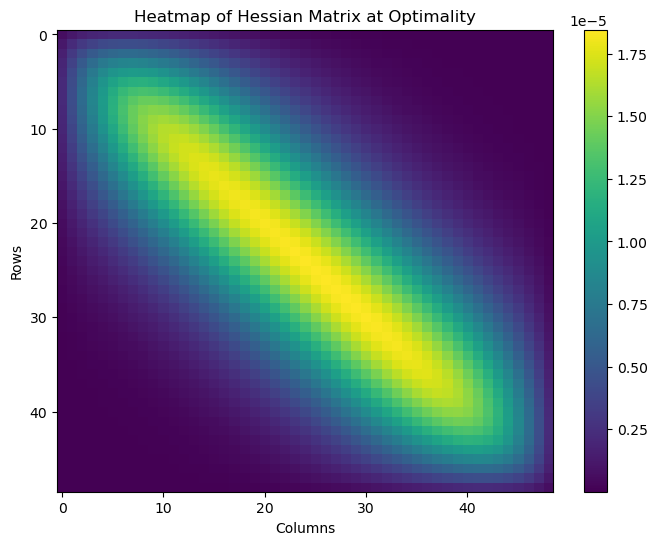

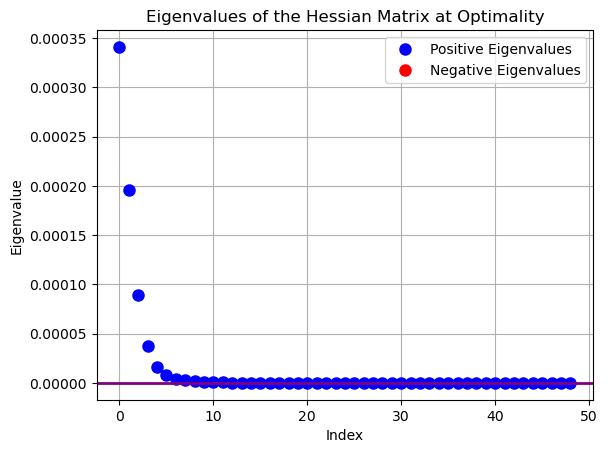

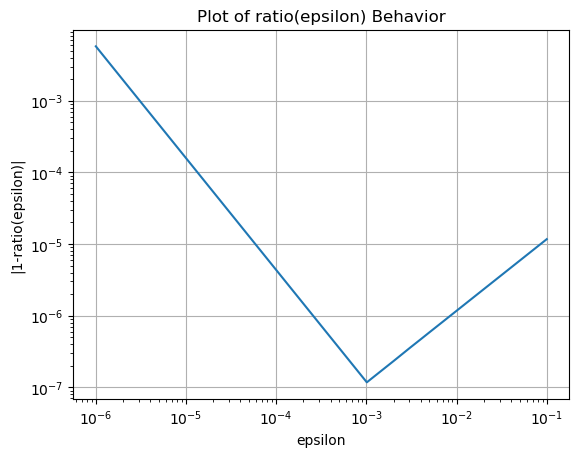

In [138]:
KPP(1,1)